# Let's Face It 

**Team Members:** Georgiy Sekretaryuk, Rafael Arbex-Murut, Yeshwanth Somu

**Data Set:** Facial Recognition Dataset
- https://www.kaggle.com/datasets/apollo2506/facial-recognition-dataset?select=Testing

**Data Set Description:**

This dataset contains folders pertaining to different expressions of the human face, such as Surprise, Anger, Happiness, Sad, Neutral, Fear. The training set consists of 28,079 samples in total with the testing set consisting of 7,178 samples in total. The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The purpose of this project is to analyze facial images to predict emotion.

**Number of Attributes:** 2304

**Attribute Description:** Each attribute is a grayscale value of each of the 48 x 48 pixels.

**Data Source:** Kaggle

In [1]:
# SETUP

import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import tensorflow as tf
from tensorflow import keras
from keras import metrics
from sklearn import metrics
tf.get_logger().setLevel('INFO')

2023-07-17 17:18:48.802949: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-17 17:18:48.838544: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-17 17:18:48.839195: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 17:18:49.495965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Loading Data

In [2]:
# Function to load images from a folder
def load_images_from_folder(folder_path, label_mapping):
    images = []
    labels = []

    #load each image file
    for filename in os.listdir(folder_path):
        img = Image.open(os.path.join(folder_path, filename))

        #check if loaded properly
        if img is not None:

            images.append(np.array(img)) #turn image to array
            # print(folder_path)
            folder_path = folder_path.replace("\\", "/")
            folder_name = folder_path.split("/")[-1]  # Extract folder name from path
            # print(folder_name)
            label = label_mapping[folder_name]  # Assign label based on folder name
            labels.append(label)  # Assign the folder index as the label

    return images, labels

def load_dataset(data_folder, return_label_names=False):
    X = []
    Y = []

    label_mapping = {}  # Dictionary to map folder names to label values
    label_counter = 0

    #cycle through each folder, get folder path
    for folder_name in os.listdir(data_folder):
        folder_path = os.path.join(data_folder, folder_name)
        # print("Load_dataset is looping through", folder_path)

        #check if a folder or a stray file
        if os.path.isdir(folder_path):

            #count folders to assign index
            label_mapping[folder_name] = label_counter
            label_counter += 1

            #load images and labels, add to X/Y list
            images, labels = load_images_from_folder(folder_path, label_mapping)
            X.extend(images)
            Y.extend(labels)
    
        else:
            print(f"{folder_path} is not a folder.")

    #pull out label names
    label_names = list(label_mapping.keys())

    if return_label_names:
        label_names = list(label_mapping.keys())
        return np.array(X), np.array(Y), label_names
    else:
        return np.array(X), np.array(Y)

# Load the training dataset
train_folder = 'data/Training/Training'
X_train, Y_train, label_names = load_dataset(train_folder, return_label_names=True)

# Load the testing dataset
test_folder = 'data/Testing/Testing'
X_test, Y_test, = load_dataset(test_folder)

# Flatten the label vectors
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()


data/Testing/Testing/.DS_Store is not a folder.


In [3]:
print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)
print("X_test.shape:", X_test.shape)
print("Y_test.shape:", Y_test.shape)

print(label_names)

print(Y_train)

X_train.shape: (28273, 48, 48)
Y_train.shape: (28273,)
X_test.shape: (7067, 48, 48)
Y_test.shape: (7067,)
['Happy', 'Suprise', 'Angry', 'Neutral', 'Fear', 'Sad']
[0 0 0 ... 5 5 5]


In [5]:
len(Y_train[Y_train == 0])

7215

In [ ]:
fig, axs = plt.subplots(1)
axs.hist(Y_train, bins=np.arange(2, 12)/2)
plt.xticks(range(len(label_names)), labels=label_names)

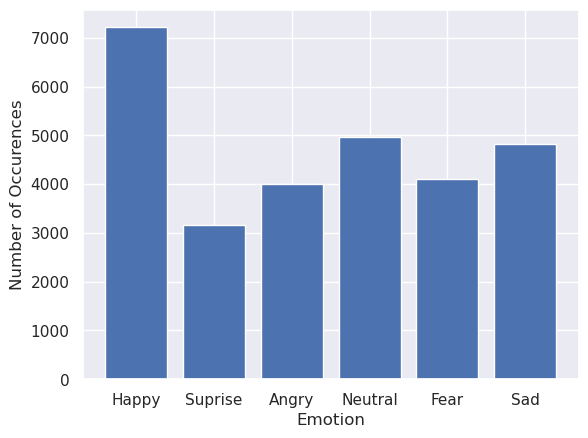

In [8]:
n = [len(Y_train[Y_train == 0]), len(Y_train[Y_train == 1]), len(Y_train[Y_train == 2]), len(Y_train[Y_train == 3]), len(Y_train[Y_train == 4]), len(Y_train[Y_train == 5])]
plt.bar(label_names, n)
plt.xlabel("Emotion")
plt.ylabel ("Number of Occurences")
plt.show()

In [ ]:
s = pd.Series(Y_train).replace({0:"Happy", 1:"Surprise", 2:"Angry", 3:"Neutral", 4:"Fear", 5:"Sad"}).value_counts()
plt.hist(s)

In [ ]:
X_train = X_train / 255
X_test = X_test / 255

### Visualizing Images in Dataset

In [ ]:
#plot 5 images for each label

num_images_to_show = 5

fig, axs = plt.subplots(len(label_names), ncols=num_images_to_show, figsize=(10, 12))
for label in range(len(label_names)):
    counter = 0 
    for i in range(len(Y_train)):
        if Y_train[i] == label:
            image = X_train[i]
            axs[label, counter].imshow(image, cmap='gray')
            axs[label, counter].set_title(label_names[label])
            axs[label, counter].axis('off')
            counter += 1

            #if loaded 5 images per row/label, break
            if counter == 5:  
                break
plt.show()

### Building the Model

In [ ]:
# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

In [ ]:
def build_model(n_classes, learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of classes in the dataset
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  model = keras.Sequential()
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(
      units=n_classes,
      activation='softmax'
  ))

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
  model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
                optimizer=optimizer, 
                metrics=['accuracy'])
  return model

In [ ]:
model = build_model(len(label_names), 0.0001)

history = model.fit(
  x = X_train,
  y = Y_train,
  epochs=10,
  batch_size=64,
  validation_split=0.1,
  verbose=1)

history = pd.DataFrame(history.history)
display(history)

In [ ]:
test_predictions = np.argmax(model.predict(X_test), axis=-1)
print(test_predictions)

In [ ]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(Y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.4g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

print(metrics.classification_report(Y_test, test_predictions, digits=3))

## Pixel Analysis

In [ ]:
first_coord = 24
second_coord = 24

angry_faces = X_train[np.where(Y_train == 0)]
angry_center = []
for i in range(0,len(angry_faces)): angry_center.append(angry_faces[i][first_coord,second_coord])
print("Mean of all angry images' center pixel is: ", np.mean(angry_center))
print("Standard Deviation of all sneaker images' center pixel is: ", np.std(angry_center))
print("\n")


fear_faces = X_train[np.where(Y_train == 1)]
fear_center = []
for i in range(0,len(fear_faces)): fear_center.append(fear_faces[i][first_coord,second_coord])
print("Mean of all fear images' center pixel is: ", np.mean(fear_center))
print("Standard Deviation of all fear images' center pixel is: ", np.std(fear_center))
print("\n")

happy_faces = X_train[np.where(Y_train == 2)]
happy_center = []
for i in range(0,len(happy_faces)): happy_center.append(happy_faces[i][first_coord,second_coord])
print("Mean of all happy images' center pixel is: ", np.mean(happy_center))
print("Standard Deviation of all happy images' center pixel is: ", np.std(happy_center))
print("\n")

neutral_faces = X_train[np.where(Y_train == 3)]
neutral_center = []
for i in range(0,len(neutral_faces)): neutral_center.append(neutral_faces[i][first_coord,second_coord])
print("Mean of all neutral images' center pixel is: ", np.mean(neutral_center))
print("Standard Deviation of all neutral images' center pixel is: ", np.std(neutral_center))
print("\n")

sad_faces = X_train[np.where(Y_train == 4)]
sad_center = []
for i in range(0,len(sad_faces)): sad_center.append(sad_faces[i][first_coord,second_coord])
print("Mean of all sad images' center pixel is: ", np.mean(sad_center))
print("Standard Deviation of all sad images' center pixel is: ", np.std(sad_center))
print("\n")

surprise_faces = X_train[np.where(Y_train == 5)]
surprise_center = []
for i in range(0,len(surprise_faces)): surprise_center.append(surprise_faces[i][first_coord,second_coord])
print("Mean of all suprise images' center pixel is: ", np.mean(surprise_center))
print("Standard Deviation of all suprise images' center pixel is: ", np.std(surprise_center))
print("\n")

In [ ]:
first_coord = 12
second_coord = 30

angry_faces = X_train[np.where(Y_train == 0)]
angry_center = []
for i in range(0,len(angry_faces)): angry_center.append(angry_faces[i][first_coord,second_coord])
print("Mean of all angry images' center pixel is: ", np.mean(angry_center))
print("Standard Deviation of all sneaker images' center pixel is: ", np.std(angry_center))
print("\n")


fear_faces = X_train[np.where(Y_train == 1)]
fear_center = []
for i in range(0,len(fear_faces)): fear_center.append(fear_faces[i][first_coord,second_coord])
print("Mean of all fear images' center pixel is: ", np.mean(fear_center))
print("Standard Deviation of all fear images' center pixel is: ", np.std(fear_center))
print("\n")

happy_faces = X_train[np.where(Y_train == 2)]
happy_center = []
for i in range(0,len(happy_faces)): happy_center.append(happy_faces[i][first_coord,second_coord])
print("Mean of all happy images' center pixel is: ", np.mean(happy_center))
print("Standard Deviation of all happy images' center pixel is: ", np.std(happy_center))
print("\n")

neutral_faces = X_train[np.where(Y_train == 3)]
neutral_center = []
for i in range(0,len(neutral_faces)): neutral_center.append(neutral_faces[i][first_coord,second_coord])
print("Mean of all neutral images' center pixel is: ", np.mean(neutral_center))
print("Standard Deviation of all neutral images' center pixel is: ", np.std(neutral_center))
print("\n")

sad_faces = X_train[np.where(Y_train == 4)]
sad_center = []
for i in range(0,len(sad_faces)): sad_center.append(sad_faces[i][first_coord,second_coord])
print("Mean of all sad images' center pixel is: ", np.mean(sad_center))
print("Standard Deviation of all sad images' center pixel is: ", np.std(sad_center))
print("\n")

surprise_faces = X_train[np.where(Y_train == 5)]
surprise_center = []
for i in range(0,len(surprise_faces)): surprise_center.append(surprise_faces[i][first_coord,second_coord])
print("Mean of all suprise images' center pixel is: ", np.mean(surprise_center))
print("Standard Deviation of all suprise images' center pixel is: ", np.std(surprise_center))
print("\n")

In [ ]:
label_names